# New York City - Taxi and Limousine Commission
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
from typing import List, Tuple, Dict, Any, Union
import sys
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
settings = {
    'max_columns': 50,
    'max_colwidth': 100,
    # 'min_rows':40,
    'max_rows': 200,
    # 'precision': 3,
    'float_format': lambda x: f'{x:,.2f}',
    }
for option, value in settings.items():
    pd.set_option("display.{}".format(option), value)
import matplotlib.pyplot as plt

In [2]:
# from data_exploration_helper import (
#     nulls_uniques_count,
# )

In [3]:
def nulls_uniques_count(df: pd.DataFrame, include_cols: List[str] = [], exclude_cols: List[str] = []) -> pd.DataFrame:
    cols = df.columns if len(include_cols)==0 else list(set(df.columns).intersection(set(include_cols)))
    if len(exclude_cols)>0:
        cols = set(cols)-set(exclude_cols)
        
    nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in cols ]
    nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
    nulls_uniques_count_df.set_index('col', inplace=True)
    nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
    nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
    return nulls_uniques_count_df

# Load Data
Just one data file to explore

In [4]:
!ls -lRh /data/nyc_tlc_trip_records/2023/

/data/nyc_tlc_trip_records/2023/:
total 3.7G
-rw-rw-r--. 1 pmolnar pmolnar 452M Mar 20  2023 fhvhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar 438M May  1  2023 fhvhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar 499M May 19  2023 fhvhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar 470M Jun 23  2023 fhvhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar 490M Jul 26  2023 fhvhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmolnar pmolnar 476M Aug 22  2023 fhvhv_tripdata_2023-06.parquet
-rw-rw-r--. 1 pmolnar pmolnar 470M Sep 21  2023 fhvhv_tripdata_2023-07.parquet
-rw-rw-r--. 1 pmolnar pmolnar  11M Mar 20  2023 fhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar  13M May  1  2023 fhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M May 19  2023 fhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar  14M Jun 23  2023 fhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M Jul 26  2023 fhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmo

In [5]:
df = pd.read_parquet('/data/nyc_tlc_trip_records/2023/yellow_tripdata_2023-07.parquet')
print(f"Number of records: {df.shape[0]:,}")

Number of records: 2,907,108


In [6]:
display(df.dtypes)

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-07-01 00:29:59,2023-07-01 00:40:15,1.00,1.80,1.00,N,140,263,1,12.10,3.50,0.50,5.10,0.00,1.00,22.20,2.50,0.00
1,2,2023-07-01 00:03:25,2023-07-01 00:23:44,1.00,2.31,1.00,N,163,163,2,19.10,1.00,0.50,0.00,0.00,1.00,24.10,2.50,0.00
2,2,2023-07-01 00:38:29,2023-07-01 00:48:53,1.00,2.36,1.00,N,142,262,1,13.50,1.00,0.50,3.70,0.00,1.00,22.20,2.50,0.00
3,2,2023-07-01 00:14:16,2023-07-01 00:29:13,1.00,4.36,1.00,N,68,24,1,19.80,1.00,0.50,4.96,0.00,1.00,29.76,2.50,0.00
4,1,2023-07-01 00:11:15,2023-07-01 00:20:47,0.00,1.60,1.00,N,161,107,1,11.40,3.50,0.50,3.25,0.00,1.00,19.65,2.50,0.00


In [8]:
df.shape[1]

19

In [9]:
df.describe().shape[1]

18

In [10]:
!ls -lR /data/nyc_tlc_trip_records/

/data/nyc_tlc_trip_records/:
total 64
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2009
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2010
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2011
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2012
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2013
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2014
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2015
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2016
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2017
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2018
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2019
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2020
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2021
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2022
drwxrwxr-x. 2 pmolnar pmolnar 4096 Sep 27  2023 2023
-rw-------. 1 pmolnar pmolnar 1339 Sep 27  2023 README.md

/data/nyc_tlc_trip_records/2009:
total 5583504
-rw-rw-r--. 1 pmolnar pmolnar 469759995 Jun 29  2022 yellow_t

# Data Quality Table

In [11]:
data_quality_1 = df.describe(include=['int64', 'float64']).T
display(data_quality_1)

,count,mean,std,min,25%,50%,75%,max
passenger_count,"2,822,022.00",1.40,0.92,0.00,1.00,1.00,1.00,9.00
trip_distance,"2,907,108.00",4.49,257.88,0.00,1.06,1.81,3.58,"191,944.96"
RatecodeID,"2,822,022.00",1.61,7.19,1.00,1.00,1.00,1.00,99.00
payment_type,"2,907,108.00",1.21,0.57,0.00,1.00,1.00,1.00,4.00
fare_amount,"2,907,108.00",19.70,19.84,-602.90,9.30,13.50,21.90,"1,040.40"
extra,"2,907,108.00",1.54,1.85,-10.00,0.00,1.00,2.50,67.33
mta_tax,"2,907,108.00",0.48,0.11,-0.50,0.50,0.50,0.50,4.00
tip_amount,"2,907,108.00",3.45,4.14,-95.00,0.00,2.72,4.34,443.05
tolls_amount,"2,907,108.00",0.60,2.22,-91.30,0.00,0.00,0.00,114.55
improvement_surcharge,"2,907,108.00",0.98,0.21,-1.00,1.00,1.00,1.00,1.00


In [12]:
data_quality_2 = df.describe(exclude=['int64', 'float64', 'datetime']).T
display(data_quality_2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
VendorID,"2,907,108.00",NaN,NaN,NaN,1.75,0.44,1.00,1.00,2.00,2.00,6.00
store_and_fwd_flag,2822022,2,N,2801778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,"2,907,108.00",NaN,NaN,NaN,163.23,63.72,1.00,132.00,161.00,231.00,265.00
DOLocationID,"2,907,108.00",NaN,NaN,NaN,162.23,70.05,1.00,113.00,162.00,233.00,265.00


In [13]:
df.shape

(2907108, 19)

# Missing Values and Unique Values

In [14]:
nuc = nulls_uniques_count(df)
display(nuc)

,null_values,unique,null_values_perc,unique_perc
col,,,,
VendorID,0,3,0.00,0.00
tpep_pickup_datetime,0,1583539,0.00,0.54
tpep_dropoff_datetime,0,1583648,0.00,0.54
passenger_count,85086,10,0.03,0.00
trip_distance,0,4876,0.00,0.00
RatecodeID,85086,7,0.03,0.00
store_and_fwd_flag,85086,2,0.03,0.00
PULocationID,0,255,0.00,0.00
DOLocationID,0,261,0.00,0.00


combine information

In [15]:
combined_data_quality = pd.DataFrame(df.dtypes, columns=['field_name']).join(nuc).join(data_quality_1)
display(combined_data_quality)
print(f"Shape: {combined_data_quality.shape}")

,field_name,null_values,unique,null_values_perc,unique_perc,count,mean,std,min,25%,50%,75%,max
VendorID,int32,0,3,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_pickup_datetime,datetime64[us],0,1583539,0.00,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_dropoff_datetime,datetime64[us],0,1583648,0.00,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,float64,85086,10,0.03,0.00,"2,822,022.00",1.40,0.92,0.00,1.00,1.00,1.00,9.00
trip_distance,float64,0,4876,0.00,0.00,"2,907,108.00",4.49,257.88,0.00,1.06,1.81,3.58,"191,944.96"
RatecodeID,float64,85086,7,0.03,0.00,"2,822,022.00",1.61,7.19,1.00,1.00,1.00,1.00,99.00
store_and_fwd_flag,object,85086,2,0.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,int32,0,255,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOLocationID,int32,0,261,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_type,int64,0,5,0.00,0.00,"2,907,108.00",1.21,0.57,0.00,1.00,1.00,1.00,4.00


Shape: (19, 13)


In [16]:
def data_quality_table(df: pd.DataFrame) -> pd.DataFrame:
    dt = pd.DataFrame(df.dtypes, columns=['field_name'])
    nuc = nulls_uniques_count(df)
    # des = df.describe(include='all', datetime_is_numeric=True).T
    # des = df.describe(datetime_is_numeric=True).T
    des = df.describe().T
    combined_data_quality = dt.join(nuc).join(des, how='left')
    return combined_data_quality

In [17]:
data_quality_table(df)

,field_name,null_values,unique,null_values_perc,unique_perc,count,mean,min,25%,50%,75%,max,std
VendorID,int32,0,3,0.00,0.00,"2,907,108.00",1.75,1.00,1.00,2.00,2.00,6.00,0.44
tpep_pickup_datetime,datetime64[us],0,1583539,0.00,0.54,2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN
tpep_dropoff_datetime,datetime64[us],0,1583648,0.00,0.54,2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN
passenger_count,float64,85086,10,0.03,0.00,"2,822,022.00",1.40,0.00,1.00,1.00,1.00,9.00,0.92
trip_distance,float64,0,4876,0.00,0.00,"2,907,108.00",4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88
RatecodeID,float64,85086,7,0.03,0.00,"2,822,022.00",1.61,1.00,1.00,1.00,1.00,99.00,7.19
store_and_fwd_flag,object,85086,2,0.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,int32,0,255,0.00,0.00,"2,907,108.00",163.23,1.00,132.00,161.00,231.00,265.00,63.72
DOLocationID,int32,0,261,0.00,0.00,"2,907,108.00",162.23,1.00,113.00,162.00,233.00,265.00,70.05
payment_type,int64,0,5,0.00,0.00,"2,907,108.00",1.21,0.00,1.00,1.00,1.00,4.00,0.57


# Outliers

<AxesSubplot:>

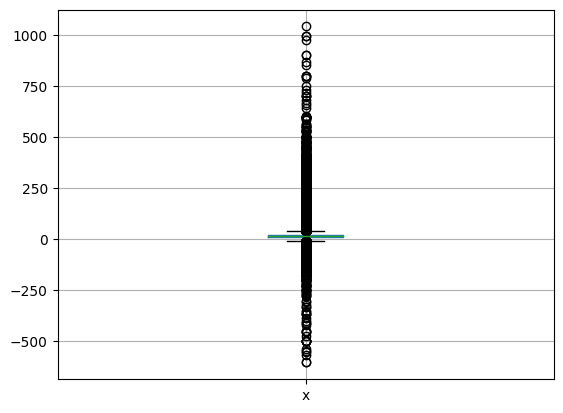

In [18]:
pd.plotting.boxplot(df.fare_amount)

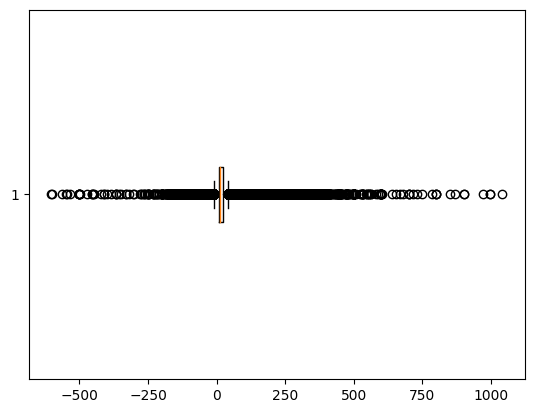

In [19]:
plt.boxplot(df.fare_amount, vert=False)
plt.show()

<AxesSubplot:>

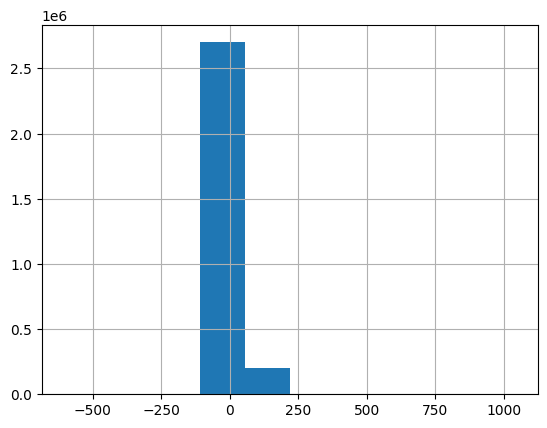

In [20]:
pd.plotting.hist_series(df.fare_amount)

In [21]:
(df.fare_amount<250).sum()

2906245

In [22]:
df1 = df[ (df.fare_amount<250) & ( df.fare_amount>0) ] 

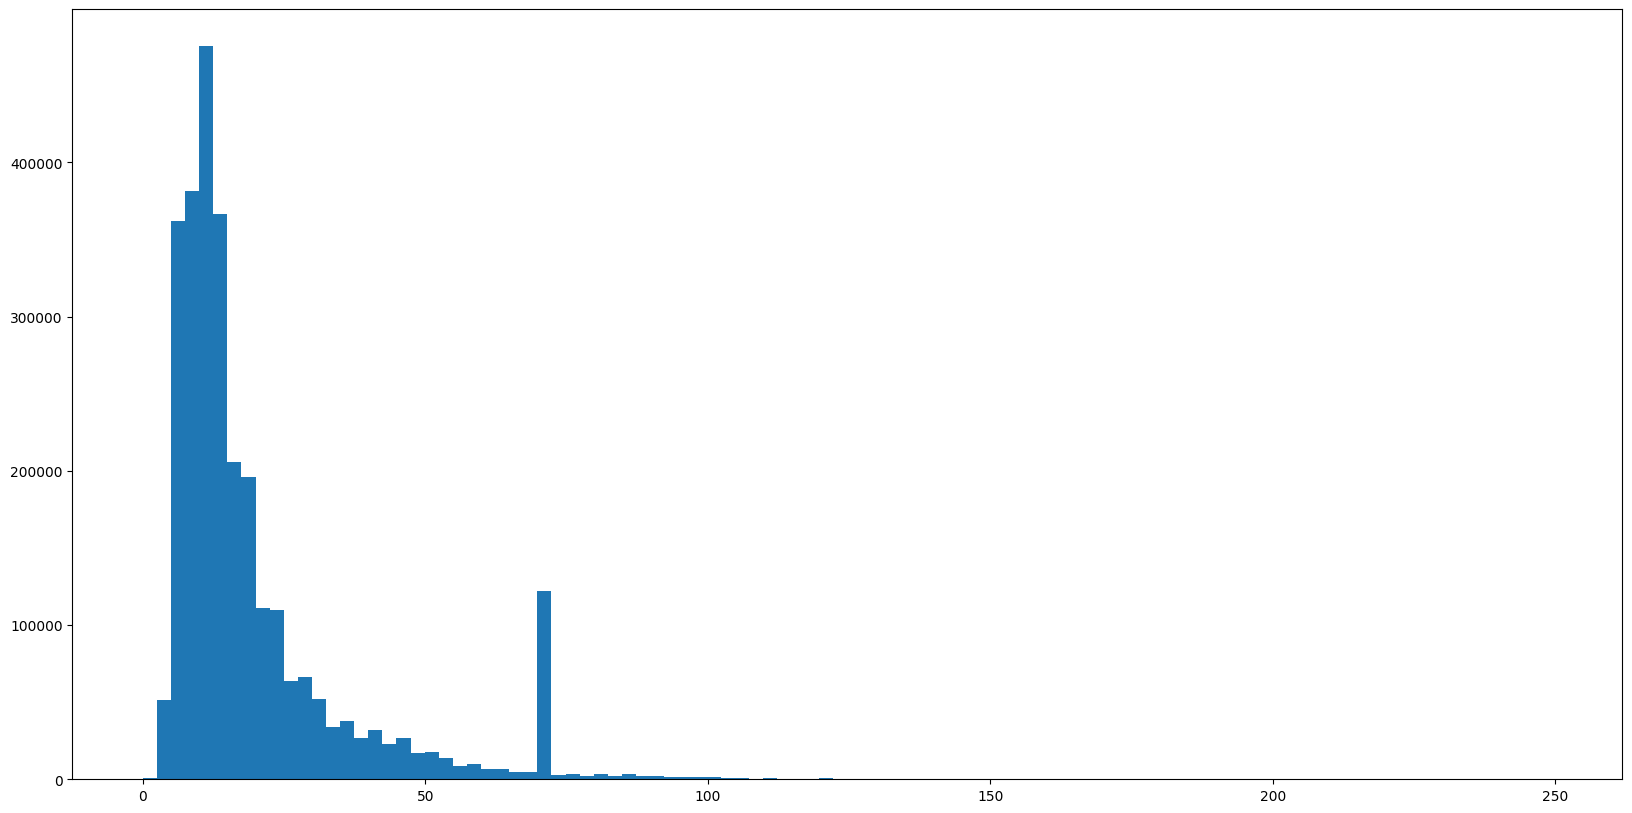

In [23]:
fig = plt.figure(figsize=(20,10))
plt.hist(df1.fare_amount, bins=100)
plt.show()

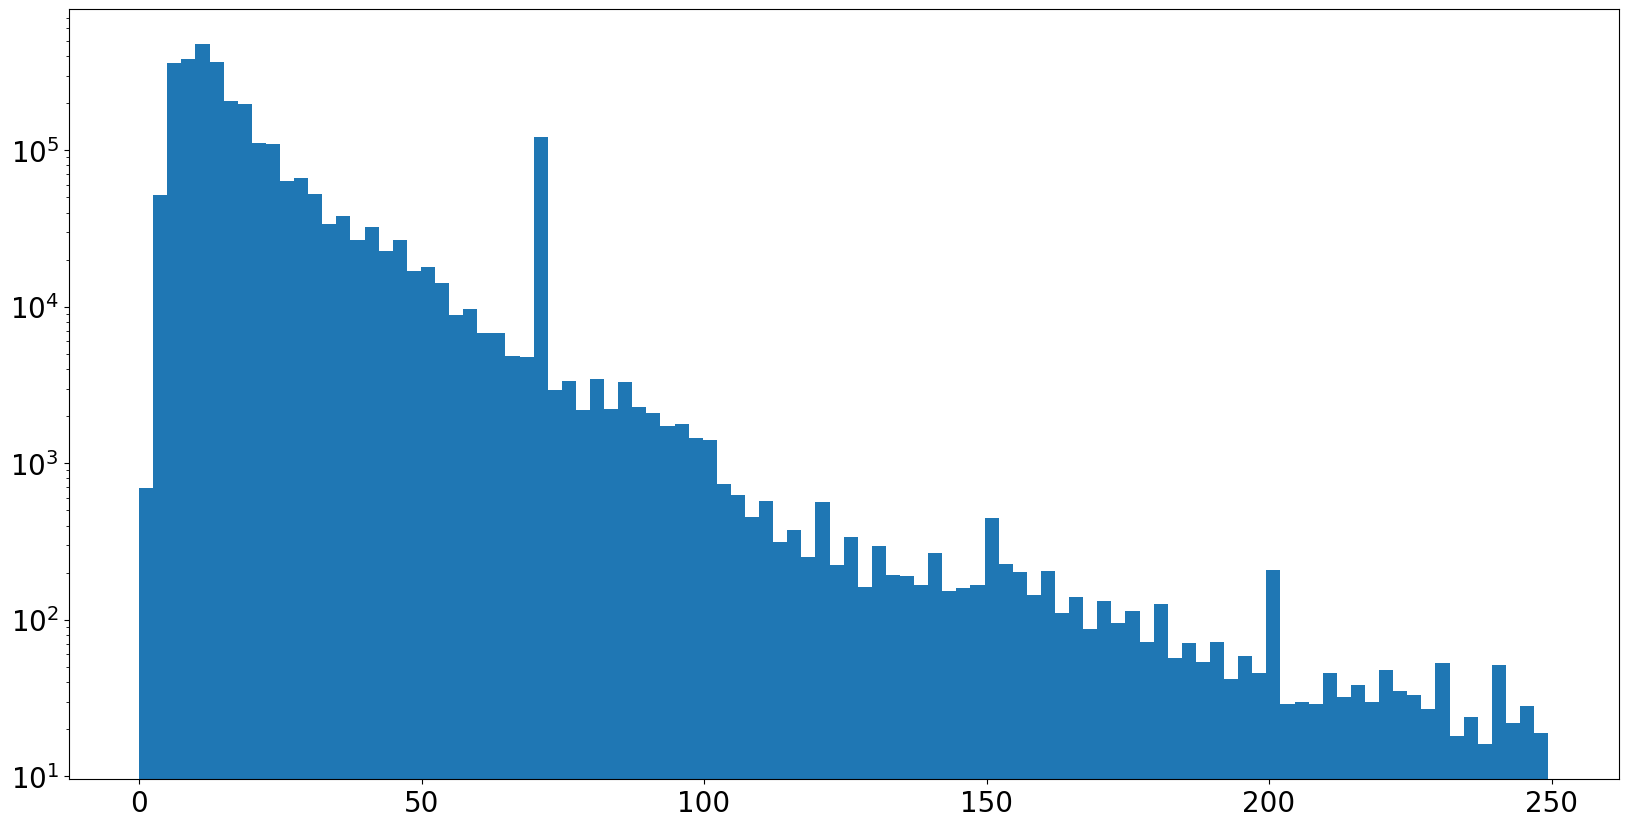

In [24]:
fig = plt.figure(figsize=(20,10))
plt.hist(df1.fare_amount, bins=100, log=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [25]:
numeric_columns = df.describe().columns
numeric_columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')

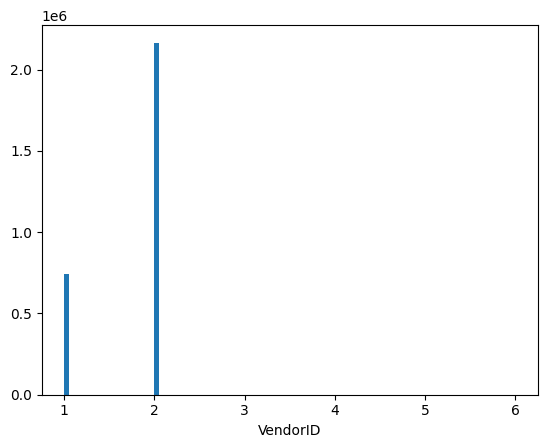

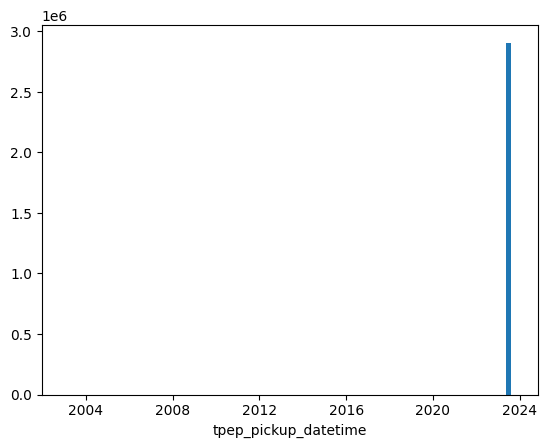

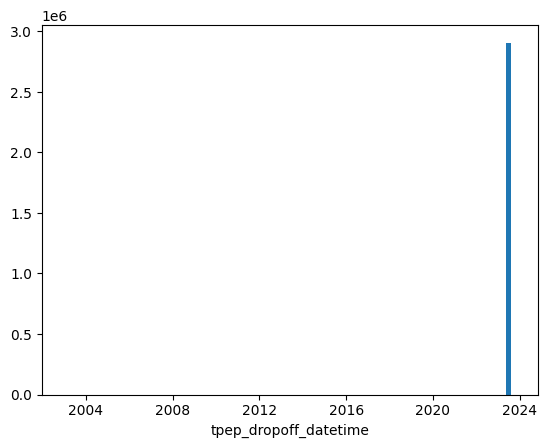

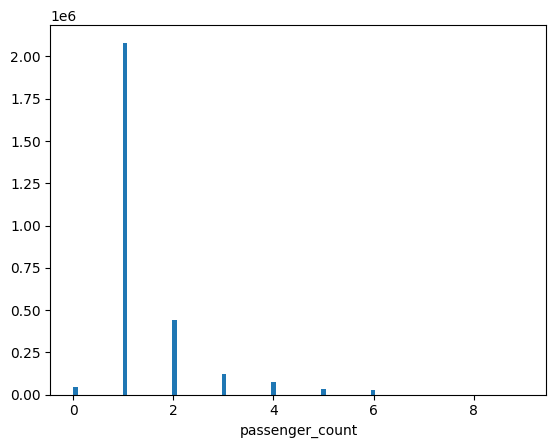

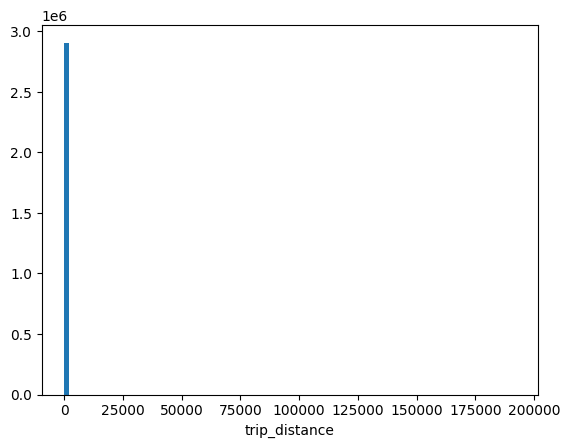

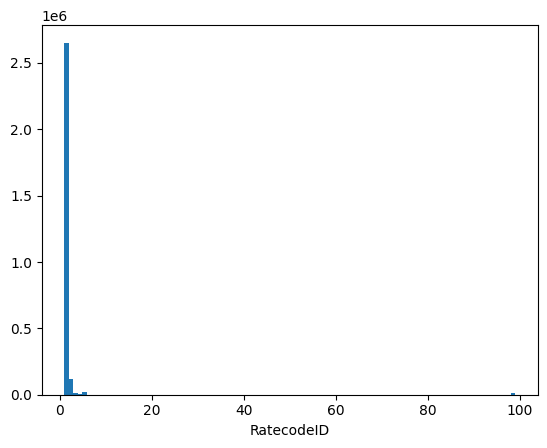

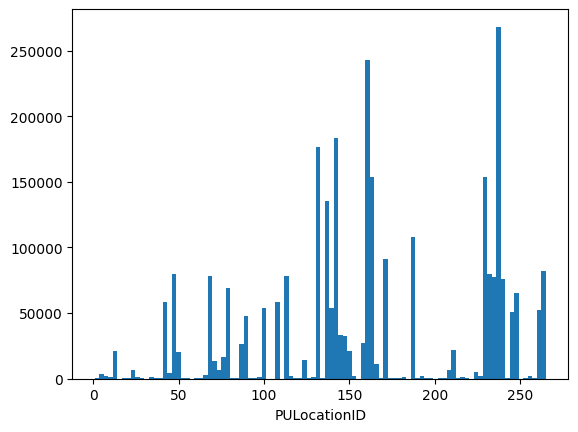

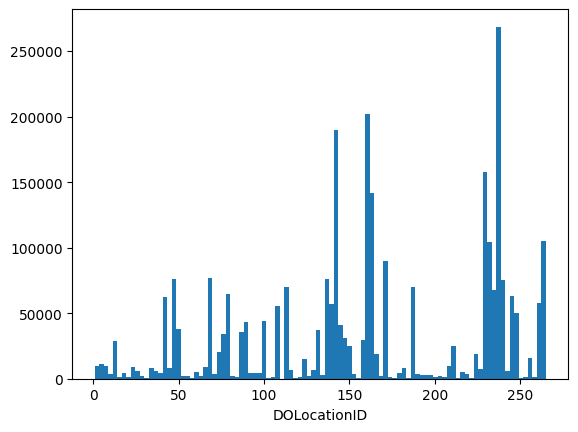

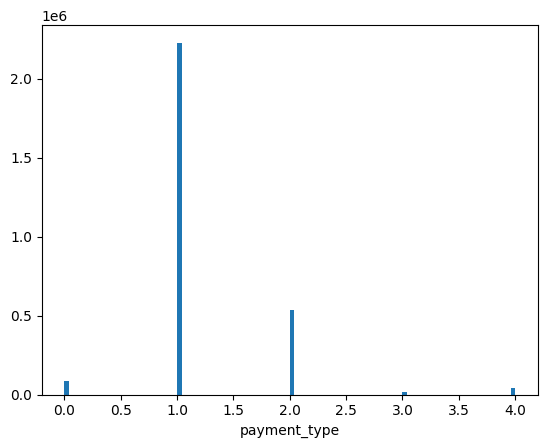

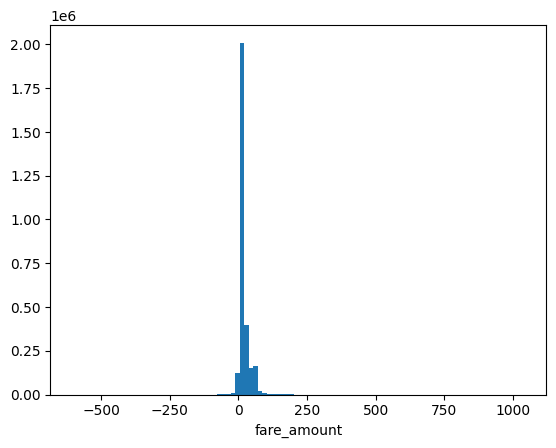

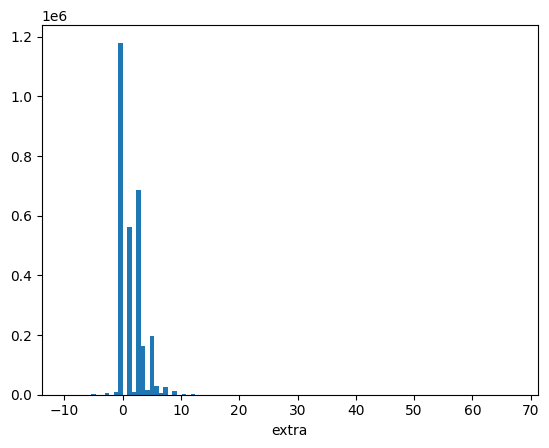

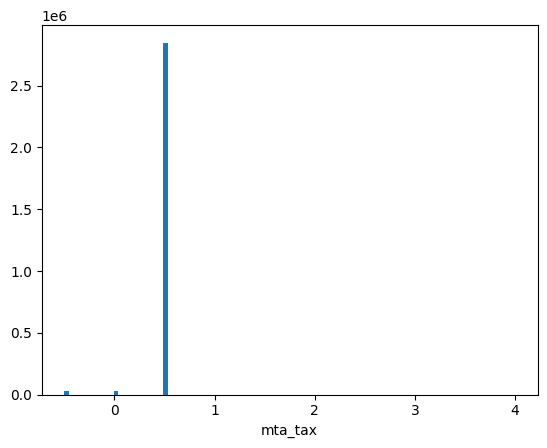

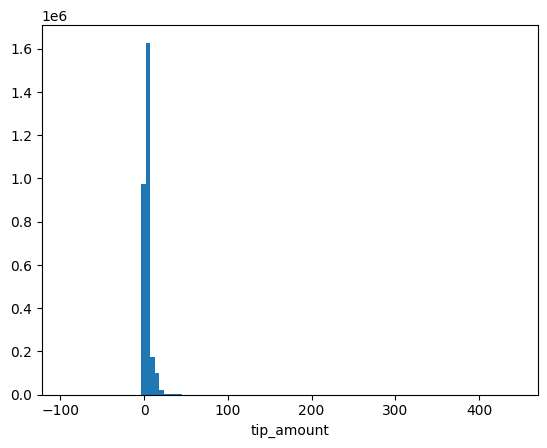

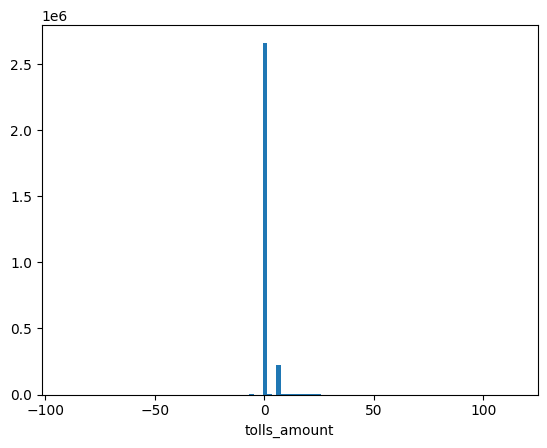

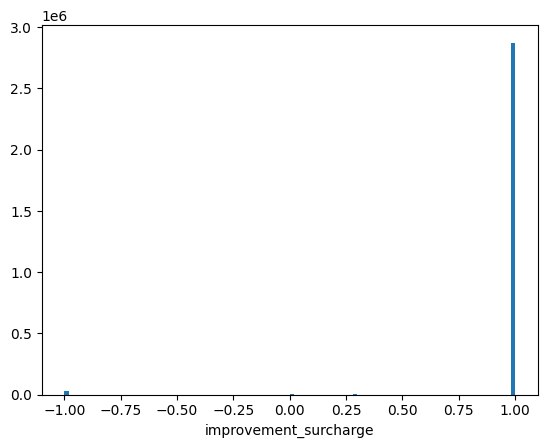

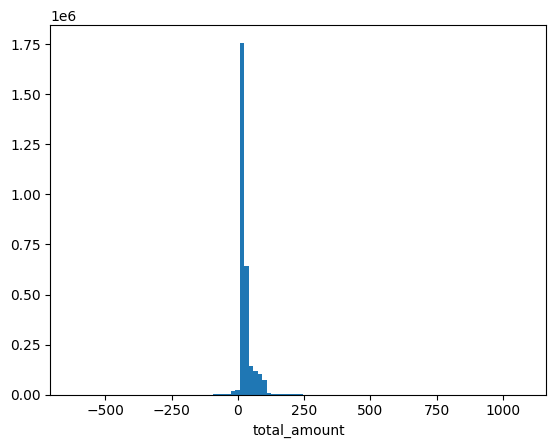

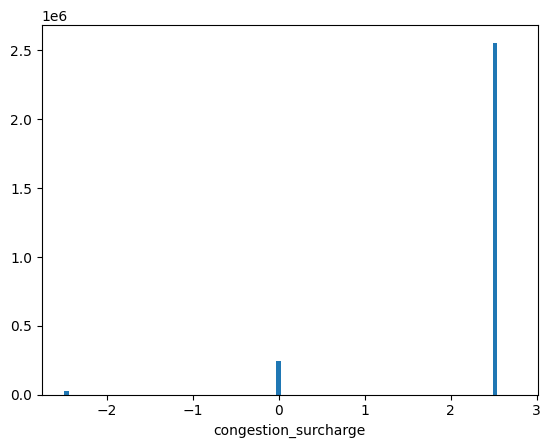

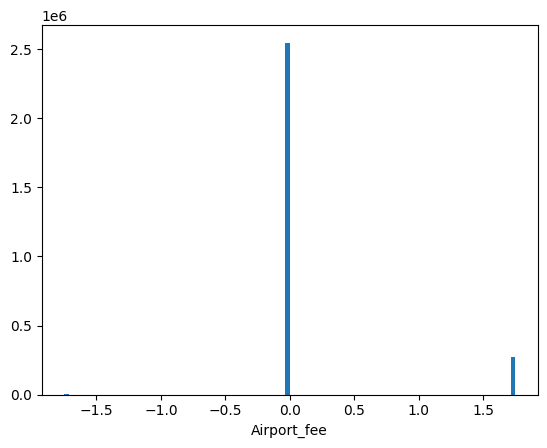

In [26]:
for col in numeric_columns:
    plt.hist(df[col], bins=100)
    plt.xlabel(col)
    plt.show()

In [27]:
# for col in numeric_columns:
#     plt.boxplot(df[col], vert=False)
#     plt.xlabel(col)
#     plt.show()

In [28]:
df[(df.fare_amount>1_000)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1004258,2,2023-07-13 08:57:00,2023-07-13 13:34:52,4.00,244.33,4.00,N,132,265,2,"1,040.40",0.00,0.00,0.00,36.30,1.00,"1,079.45",0.00,1.75


In [29]:
df[(df.fare_amount<0)].head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
44,2,2023-07-01 00:27:16,2023-07-01 00:37:09,1.00,1.89,1.00,N,163,186,4,-12.10,-1.00,-0.50,0.00,0.00,-1.00,-17.10,-2.50,0.00
46,2,2023-07-01 00:38:59,2023-07-01 00:51:35,1.00,2.84,1.00,N,186,4,2,-15.60,-1.00,-0.50,0.00,0.00,-1.00,-20.60,-2.50,0.00
167,2,2023-07-01 00:01:53,2023-07-01 00:08:03,1.00,1.03,1.00,N,48,246,4,-7.90,-1.00,-0.50,0.00,0.00,-1.00,-12.90,-2.50,0.00
365,2,2023-07-01 00:23:54,2023-07-01 00:32:50,1.00,1.61,1.00,N,100,48,4,-10.70,-1.00,-0.50,0.00,0.00,-1.00,-15.70,-2.50,0.00
397,2,2023-07-01 00:14:51,2023-07-01 00:28:01,1.00,1.85,1.00,N,114,186,4,-13.50,-1.00,-0.50,0.00,0.00,-1.00,-18.50,-2.50,0.00
409,2,2023-07-01 00:46:40,2023-07-01 00:49:31,3.00,0.59,1.00,N,238,151,2,-5.10,-1.00,-0.50,2.02,0.00,-1.00,-8.08,-2.50,0.00
660,2,2023-07-01 00:16:56,2023-07-01 00:17:49,3.00,0.05,1.00,N,79,79,4,-3.00,-1.00,-0.50,0.00,0.00,-1.00,-8.00,-2.50,0.00
699,2,2023-07-01 00:17:40,2023-07-01 00:36:14,1.00,3.81,1.00,N,230,7,4,-21.20,-1.00,-0.50,0.00,0.00,-1.00,-26.20,-2.50,0.00
752,2,2023-07-01 00:50:26,2023-07-01 00:50:51,1.00,0.05,1.00,N,42,42,3,-3.00,-1.00,-0.50,0.00,0.00,-1.00,-5.50,0.00,0.00
768,2,2023-07-01 00:48:11,2023-07-01 00:51:07,1.00,0.09,1.00,N,164,164,2,-4.40,-1.00,-0.50,0.00,0.00,-1.00,-9.40,-2.50,0.00


In [30]:
df.shape

(2907108, 19)

In [31]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
VendorID,"2,907,108.00",NaN,NaN,NaN,1.75,1.00,1.00,2.00,2.00,6.00,0.44
tpep_pickup_datetime,2907108,NaN,NaN,NaN,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN
tpep_dropoff_datetime,2907108,NaN,NaN,NaN,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN
passenger_count,"2,822,022.00",NaN,NaN,NaN,1.40,0.00,1.00,1.00,1.00,9.00,0.92
trip_distance,"2,907,108.00",NaN,NaN,NaN,4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88
RatecodeID,"2,822,022.00",NaN,NaN,NaN,1.61,1.00,1.00,1.00,1.00,99.00,7.19
store_and_fwd_flag,2822022,2,N,2801778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,"2,907,108.00",NaN,NaN,NaN,163.23,1.00,132.00,161.00,231.00,265.00,63.72
DOLocationID,"2,907,108.00",NaN,NaN,NaN,162.23,1.00,113.00,162.00,233.00,265.00,70.05
payment_type,"2,907,108.00",NaN,NaN,NaN,1.21,0.00,1.00,1.00,1.00,4.00,0.57


In [32]:
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [33]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
VendorID,"2,907,108.00",1.75,1.00,1.00,2.00,2.00,6.00,0.44
tpep_pickup_datetime,2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN
tpep_dropoff_datetime,2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN
passenger_count,"2,822,022.00",1.40,0.00,1.00,1.00,1.00,9.00,0.92
trip_distance,"2,907,108.00",4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88
RatecodeID,"2,822,022.00",1.61,1.00,1.00,1.00,1.00,99.00,7.19
PULocationID,"2,907,108.00",163.23,1.00,132.00,161.00,231.00,265.00,63.72
DOLocationID,"2,907,108.00",162.23,1.00,113.00,162.00,233.00,265.00,70.05
payment_type,"2,907,108.00",1.21,0.00,1.00,1.00,1.00,4.00,0.57
fare_amount,"2,907,108.00",19.70,-602.90,9.30,13.50,21.90,"1,040.40",19.84


In [34]:
df.describe(include=["object"]).T

,count,unique,top,freq
store_and_fwd_flag,2822022,2,N,2801778


In [35]:
df.describe(include=["datetime64"], percentiles=[]).T

,count,mean,min,50%,max
tpep_pickup_datetime,2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-17 15:12:16,2023-10-16 15:21:27
tpep_dropoff_datetime,2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-17 15:30:49,2023-10-16 21:37:44


## Missing Values

In [36]:
n_rows = df.shape[0]
for col in df.columns:
    n_null_values = pd.isnull(df[col]).sum()
    n_unique = df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    print(f"{col}: rows={n_rows:,}   nulls={n_null_values:,}   uniques={n_unique}:")
    

VendorID: rows=2,907,108   nulls=0   uniques=3:
tpep_pickup_datetime: rows=2,907,108   nulls=0   uniques=1583539:
tpep_dropoff_datetime: rows=2,907,108   nulls=0   uniques=1583648:
passenger_count: rows=2,907,108   nulls=85,086   uniques=10:
trip_distance: rows=2,907,108   nulls=0   uniques=4876:
RatecodeID: rows=2,907,108   nulls=85,086   uniques=7:
store_and_fwd_flag: rows=2,907,108   nulls=85,086   uniques=2:
PULocationID: rows=2,907,108   nulls=0   uniques=255:
DOLocationID: rows=2,907,108   nulls=0   uniques=261:
payment_type: rows=2,907,108   nulls=0   uniques=5:
fare_amount: rows=2,907,108   nulls=0   uniques=8765:
extra: rows=2,907,108   nulls=0   uniques=54:
mta_tax: rows=2,907,108   nulls=0   uniques=8:
tip_amount: rows=2,907,108   nulls=0   uniques=4437:
tolls_amount: rows=2,907,108   nulls=0   uniques=857:
improvement_surcharge: rows=2,907,108   nulls=0   uniques=5:
total_amount: rows=2,907,108   nulls=0   uniques=17999:
congestion_surcharge: rows=2,907,108   nulls=85,086  

In [37]:
def nulls_uniques_count(df: pd.DataFrame, include_cols: List[str] = [], exclude_cols: List[str] = []) -> pd.DataFrame:
    cols = df.columns if len(include_cols)==0 else list(set(df.columns).intersection(set(include_cols)))
    if len(exclude_cols)>0:
        cols = set(cols)-set(exclude_cols)
        
    nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in cols ]
    nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
    nulls_uniques_count_df.set_index('col', inplace=True)
    nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
    nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
    return nulls_uniques_count_df

In [38]:
nulls_uniques_count(df)

,null_values,unique,null_values_perc,unique_perc
col,,,,
VendorID,0,3,0.00,0.00
tpep_pickup_datetime,0,1583539,0.00,0.54
tpep_dropoff_datetime,0,1583648,0.00,0.54
passenger_count,85086,10,0.03,0.00
trip_distance,0,4876,0.00,0.00
RatecodeID,85086,7,0.03,0.00
store_and_fwd_flag,85086,2,0.03,0.00
PULocationID,0,255,0.00,0.00
DOLocationID,0,261,0.00,0.00


In [39]:
nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in df.columns
]
nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
nulls_uniques_count_df.set_index('col', inplace=True)
nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
display(nulls_uniques_count_df)
# display(nulls_uniques_count_df)

,null_values,unique,null_values_perc,unique_perc
col,,,,
VendorID,0,3,0.00,0.00
tpep_pickup_datetime,0,1583539,0.00,0.54
tpep_dropoff_datetime,0,1583648,0.00,0.54
passenger_count,85086,10,0.03,0.00
trip_distance,0,4876,0.00,0.00
RatecodeID,85086,7,0.03,0.00
store_and_fwd_flag,85086,2,0.03,0.00
PULocationID,0,255,0.00,0.00
DOLocationID,0,261,0.00,0.00


In [40]:
df.describe().T.join(nulls_uniques_count_df)

,count,mean,min,25%,50%,75%,max,std,null_values,unique,null_values_perc,unique_perc
VendorID,"2,907,108.00",1.75,1.00,1.00,2.00,2.00,6.00,0.44,0,3,0.00,0.00
tpep_pickup_datetime,2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN,0,1583539,0.00,0.54
tpep_dropoff_datetime,2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN,0,1583648,0.00,0.54
passenger_count,"2,822,022.00",1.40,0.00,1.00,1.00,1.00,9.00,0.92,85086,10,0.03,0.00
trip_distance,"2,907,108.00",4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88,0,4876,0.00,0.00
RatecodeID,"2,822,022.00",1.61,1.00,1.00,1.00,1.00,99.00,7.19,85086,7,0.03,0.00
PULocationID,"2,907,108.00",163.23,1.00,132.00,161.00,231.00,265.00,63.72,0,255,0.00,0.00
DOLocationID,"2,907,108.00",162.23,1.00,113.00,162.00,233.00,265.00,70.05,0,261,0.00,0.00
payment_type,"2,907,108.00",1.21,0.00,1.00,1.00,1.00,4.00,0.57,0,5,0.00,0.00
fare_amount,"2,907,108.00",19.70,-602.90,9.30,13.50,21.90,"1,040.40",19.84,0,8765,0.00,0.00


In [41]:
pd.DataFrame(df.dtypes, columns=['field_name']).join(df.describe().T, how='inner')

,field_name,count,mean,min,25%,50%,75%,max,std
VendorID,int32,"2,907,108.00",1.75,1.00,1.00,2.00,2.00,6.00,0.44
tpep_pickup_datetime,datetime64[us],2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN
tpep_dropoff_datetime,datetime64[us],2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN
passenger_count,float64,"2,822,022.00",1.40,0.00,1.00,1.00,1.00,9.00,0.92
trip_distance,float64,"2,907,108.00",4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88
RatecodeID,float64,"2,822,022.00",1.61,1.00,1.00,1.00,1.00,99.00,7.19
PULocationID,int32,"2,907,108.00",163.23,1.00,132.00,161.00,231.00,265.00,63.72
DOLocationID,int32,"2,907,108.00",162.23,1.00,113.00,162.00,233.00,265.00,70.05
payment_type,int64,"2,907,108.00",1.21,0.00,1.00,1.00,1.00,4.00,0.57
fare_amount,float64,"2,907,108.00",19.70,-602.90,9.30,13.50,21.90,"1,040.40",19.84


In [42]:
df.groupby('passenger_count').agg({'passenger_count': 'count'})

,passenger_count
passenger_count,
0.00,43732
1.00,2080926
2.00,438866
3.00,121774
4.00,77106
5.00,33799
6.00,25778
7.00,9
8.00,26


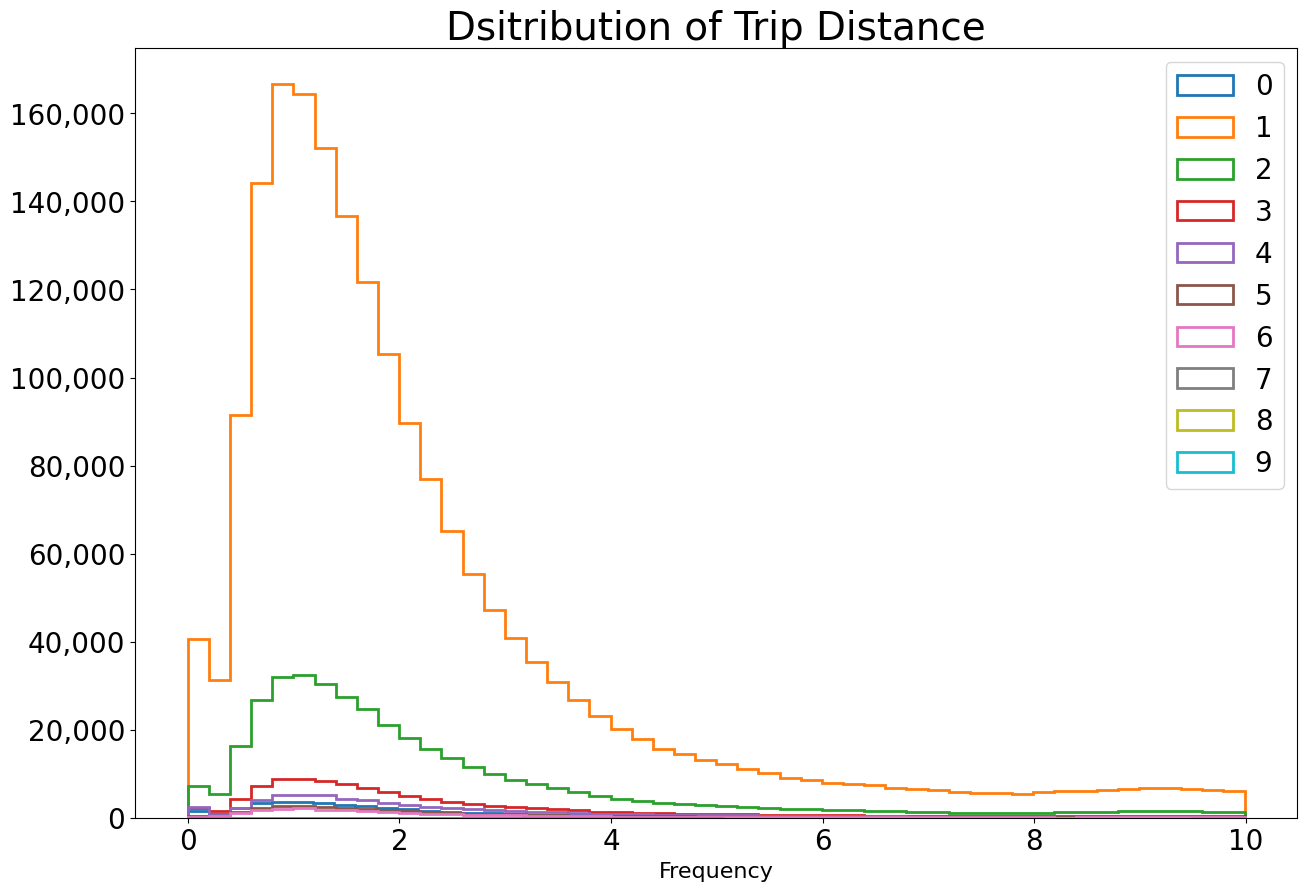

In [43]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(15,10))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Dsitribution of Trip Distance", fontsize=28)
fig.show()
fig.savefig('plot_1_15x10.png')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

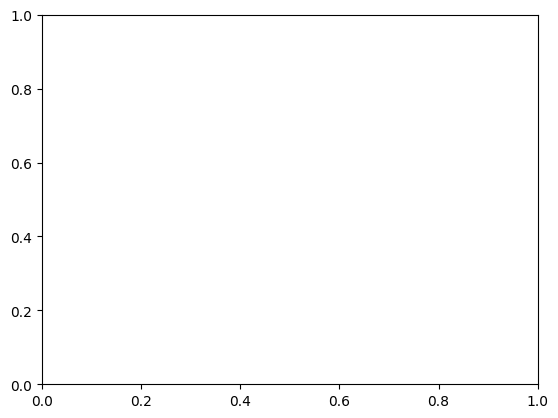

In [44]:
plt.yticks()

In [45]:
df[df.trip_distance<10]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-07-01 00:29:59,2023-07-01 00:40:15,1.00,1.80,1.00,N,140,263,1,12.10,3.50,0.50,5.10,0.00,1.00,22.20,2.50,0.00
1,2,2023-07-01 00:03:25,2023-07-01 00:23:44,1.00,2.31,1.00,N,163,163,2,19.10,1.00,0.50,0.00,0.00,1.00,24.10,2.50,0.00
2,2,2023-07-01 00:38:29,2023-07-01 00:48:53,1.00,2.36,1.00,N,142,262,1,13.50,1.00,0.50,3.70,0.00,1.00,22.20,2.50,0.00
3,2,2023-07-01 00:14:16,2023-07-01 00:29:13,1.00,4.36,1.00,N,68,24,1,19.80,1.00,0.50,4.96,0.00,1.00,29.76,2.50,0.00
4,1,2023-07-01 00:11:15,2023-07-01 00:20:47,0.00,1.60,1.00,N,161,107,1,11.40,3.50,0.50,3.25,0.00,1.00,19.65,2.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907103,2,2023-07-31 23:18:11,2023-07-31 23:18:23,NaN,0.00,NaN,None,106,106,0,21.58,0.00,0.50,0.00,0.00,1.00,23.08,NaN,NaN
2907104,2,2023-07-31 23:29:31,2023-07-31 23:51:17,NaN,4.97,NaN,None,238,243,0,22.12,0.00,0.50,0.00,0.00,1.00,23.62,NaN,NaN
2907105,2,2023-07-31 23:16:57,2023-07-31 23:17:25,NaN,0.03,NaN,None,141,141,0,23.93,0.00,0.50,0.00,0.00,1.00,27.93,NaN,NaN
2907106,2,2023-07-31 23:29:00,2023-07-31 23:46:00,NaN,3.24,NaN,None,65,62,0,9.54,0.00,0.50,3.00,0.00,1.00,14.04,NaN,NaN


In [46]:
len(mcolors.TABLEAU_COLORS)

10

list(mcolors.TABLEAU_COLORS)

In [47]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [48]:
# List of numeric columns
num_cols = [ col for col, datyp in df.dtypes.items() if datyp in ['int64', 'float64'] ]

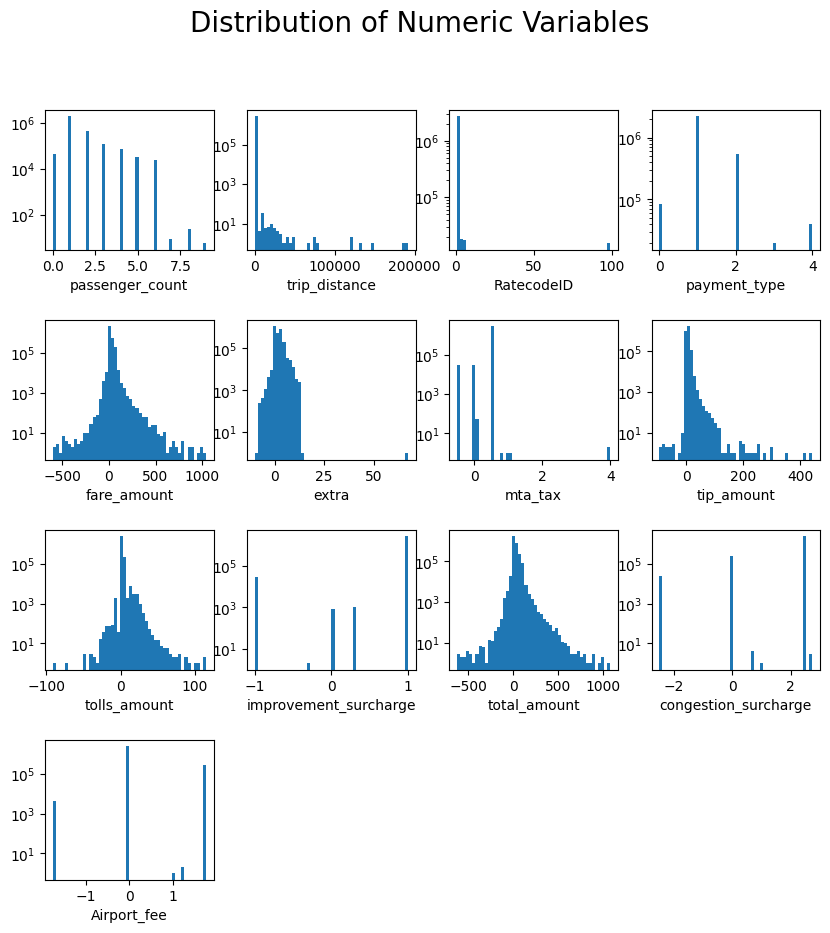

In [49]:
import math
a = math.ceil(math.sqrt(len(num_cols)))
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5)
j = 0
for col in num_cols:
    j += 1
    plt.subplot(a, a, j)
    plt.hist(df[col], bins=50, log=True)
    plt.xlabel(col)
plt.suptitle("Distribution of Numeric Variables", fontsize=20)
plt.show()

In [50]:
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

In [51]:
df2 = df.sample(1000)
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

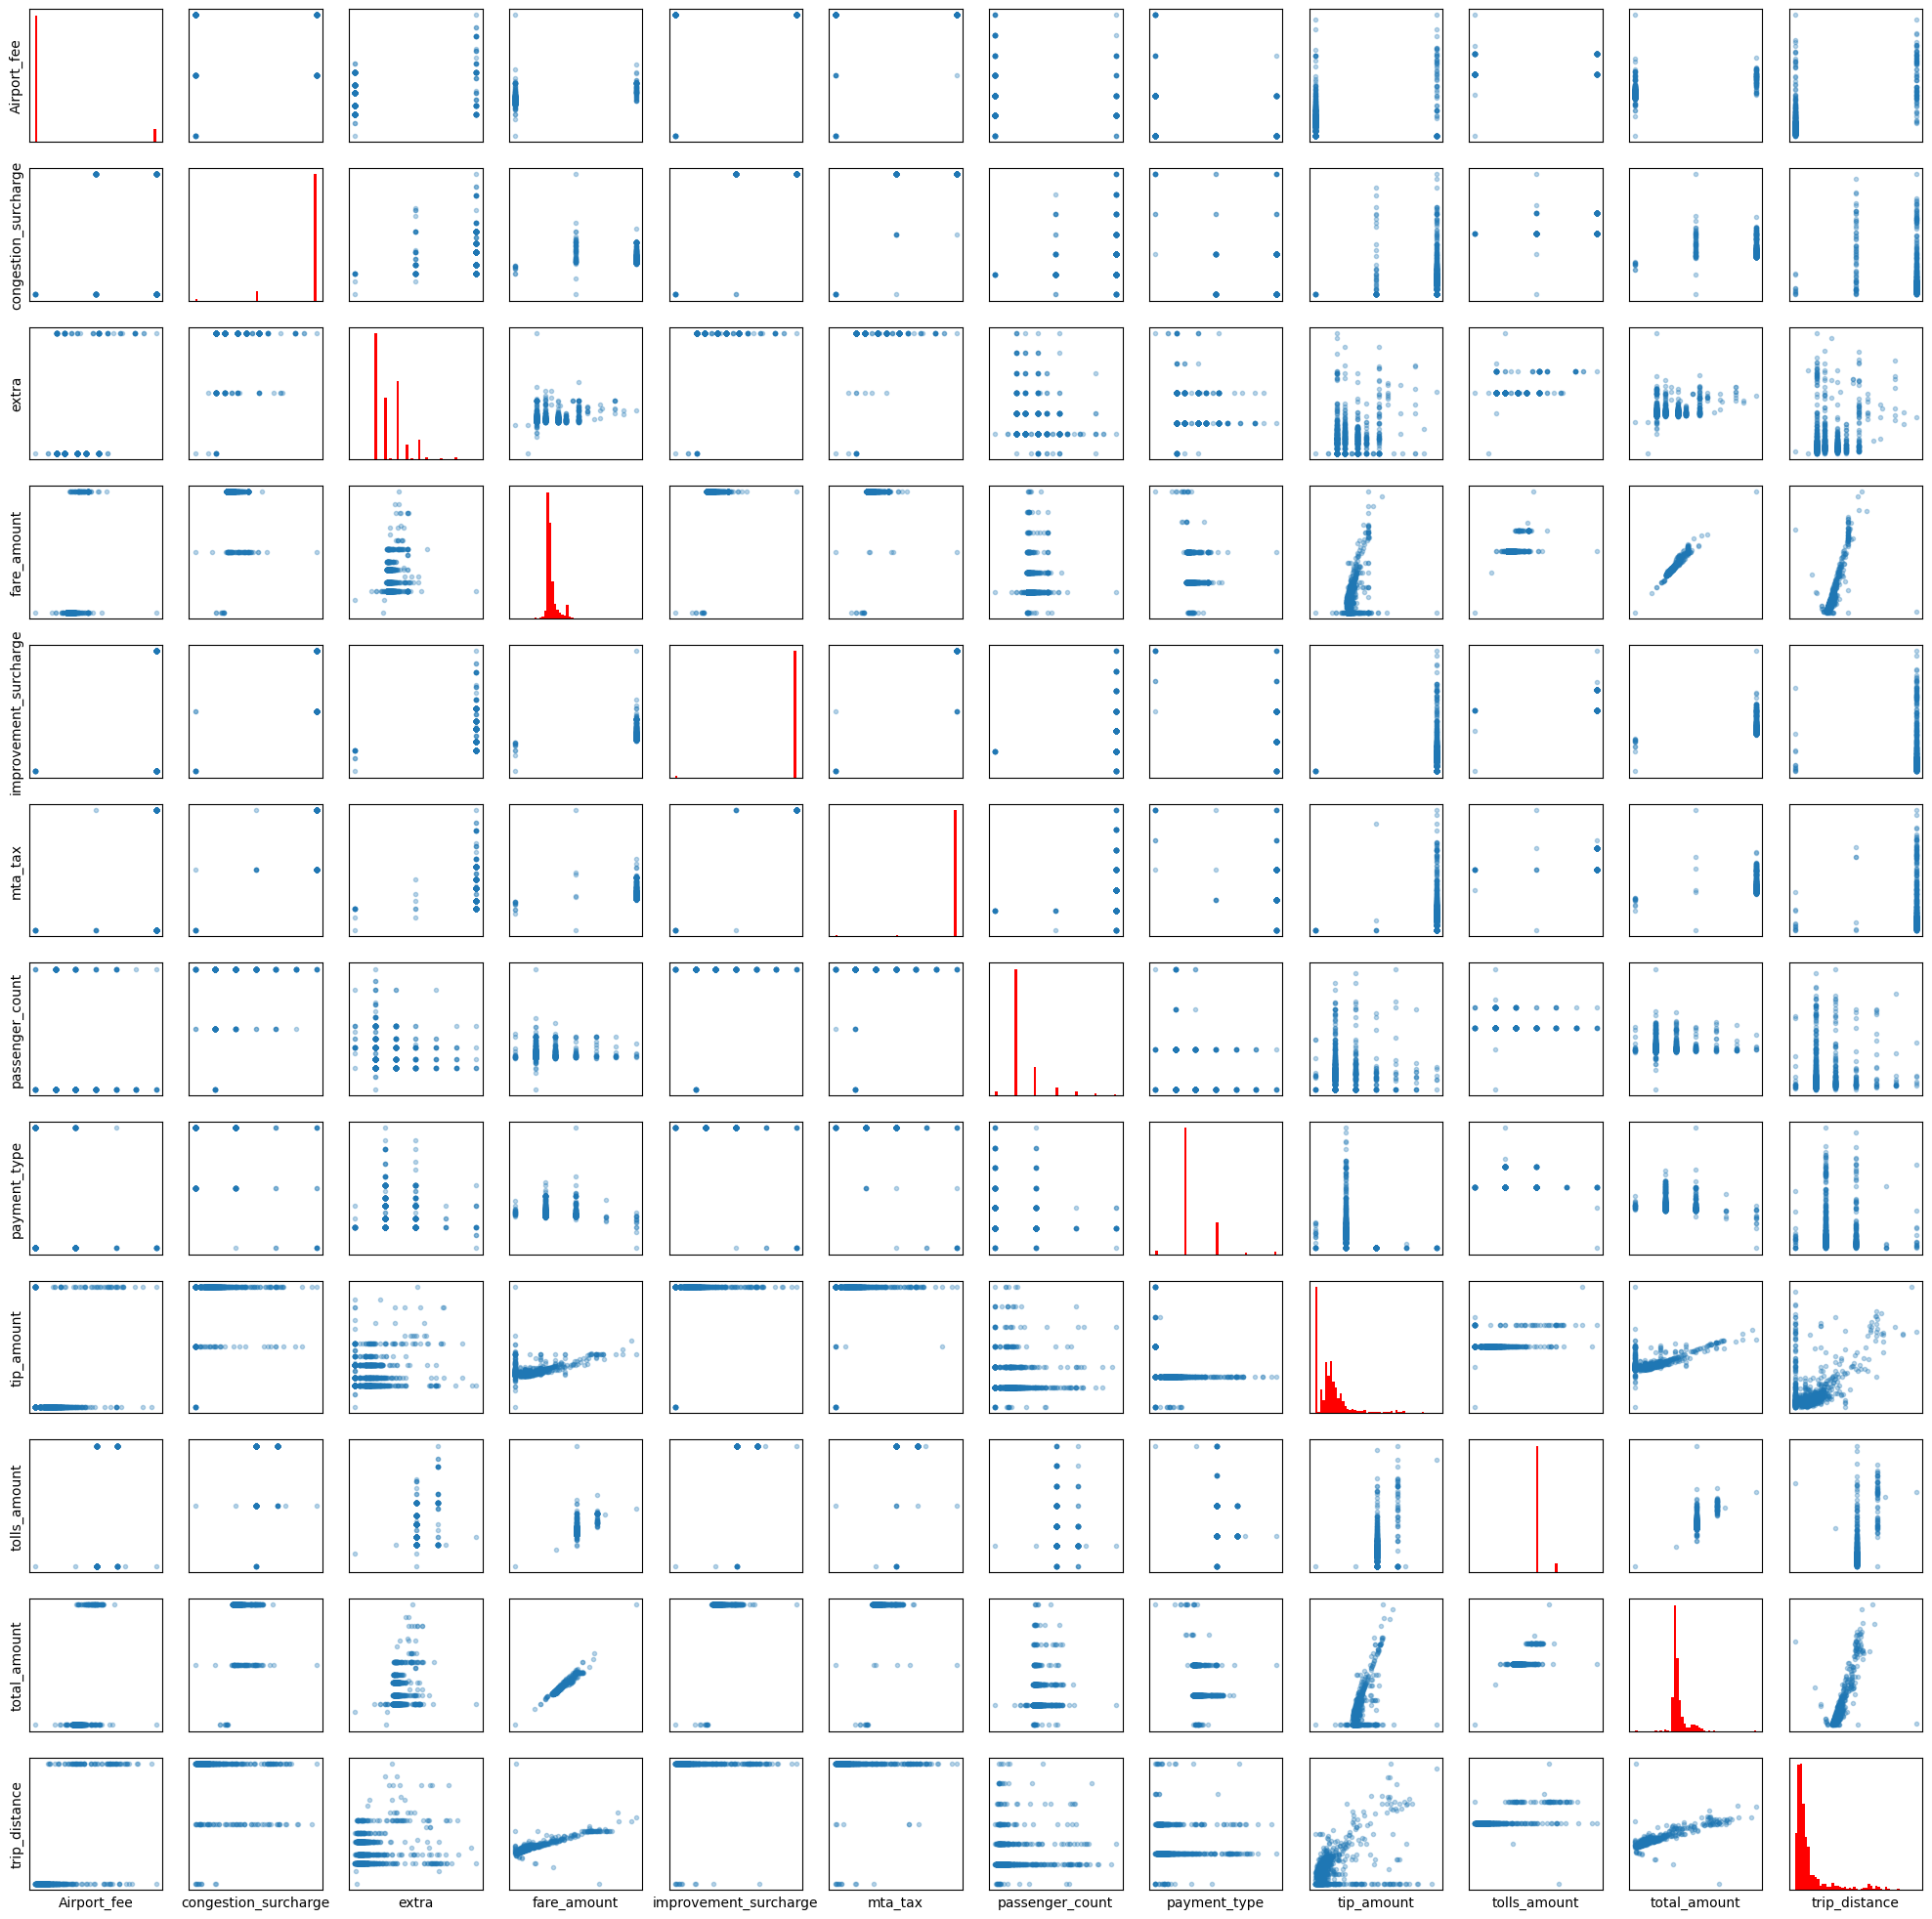

In [52]:
j = 0
n_scatt = len(scatt_cols)
fig = plt.figure(figsize=(25,25))
for row in sorted(scatt_cols):
    for col in sorted(scatt_cols):
        j += 1
        plt.subplot(n_scatt, n_scatt, j)
        if row == col:
            plt.hist(df2[col], bins=50, color='r')
        else:
            plt.plot(df2[row].to_numpy(), df2[col].to_numpy(), '.', alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        if j % n_scatt == 1:
            plt.ylabel(row)
        if j / n_scatt > n_scatt - 1:
             plt.xlabel(col)
plt.show()

In [53]:
df.trip_distance.corr(df.total_amount)

0.016973941431342766

{'whiskers': [<matplotlib.lines.Line2D at 0x7f189eacdf70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f189eacdf40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f18b8293f40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f189ead9c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f189ead9430>],
 'means': []}

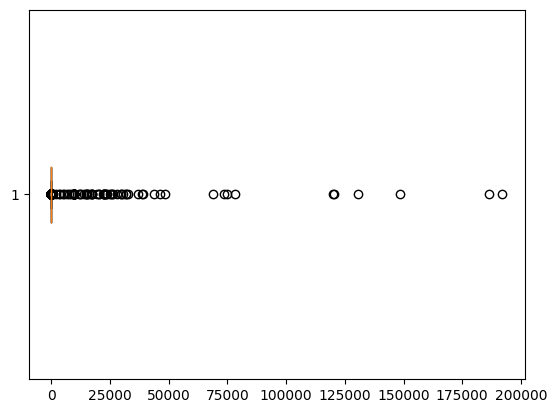

In [54]:
plt.boxplot(df.trip_distance, vert=False)

# PowerPoint

The default dimensions of a Powepoint slide are 13.33 inches by 7.5 inches.

E.g, a single figure on the slide can have the dimensions of 11x6.5

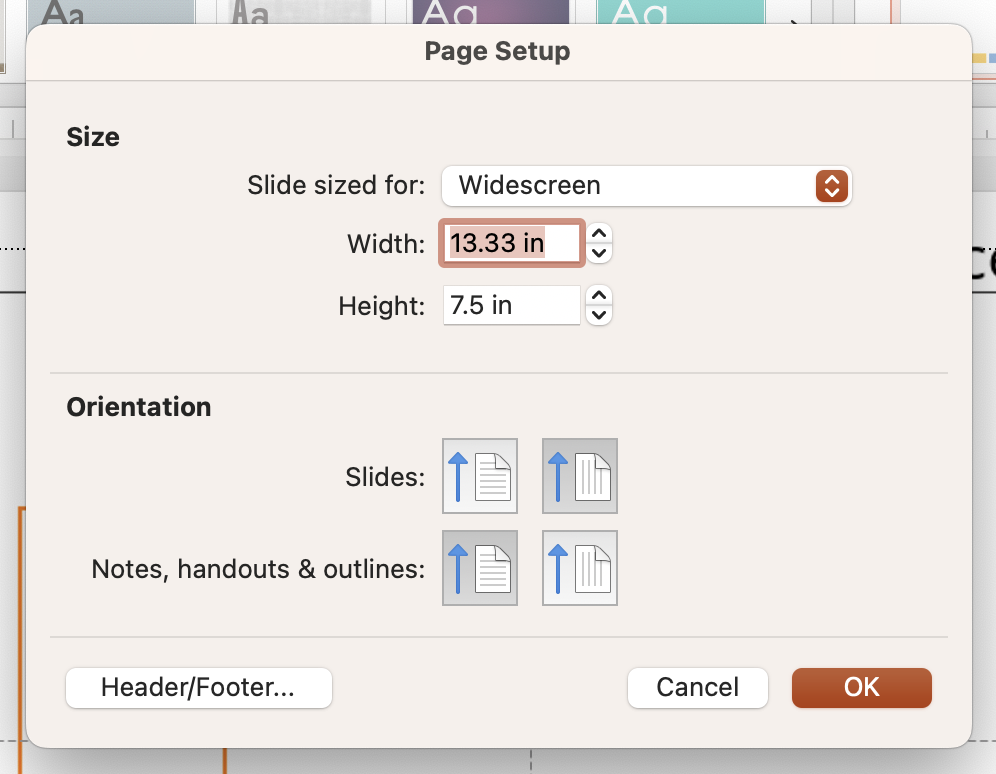

## Distribution of Trip Distance

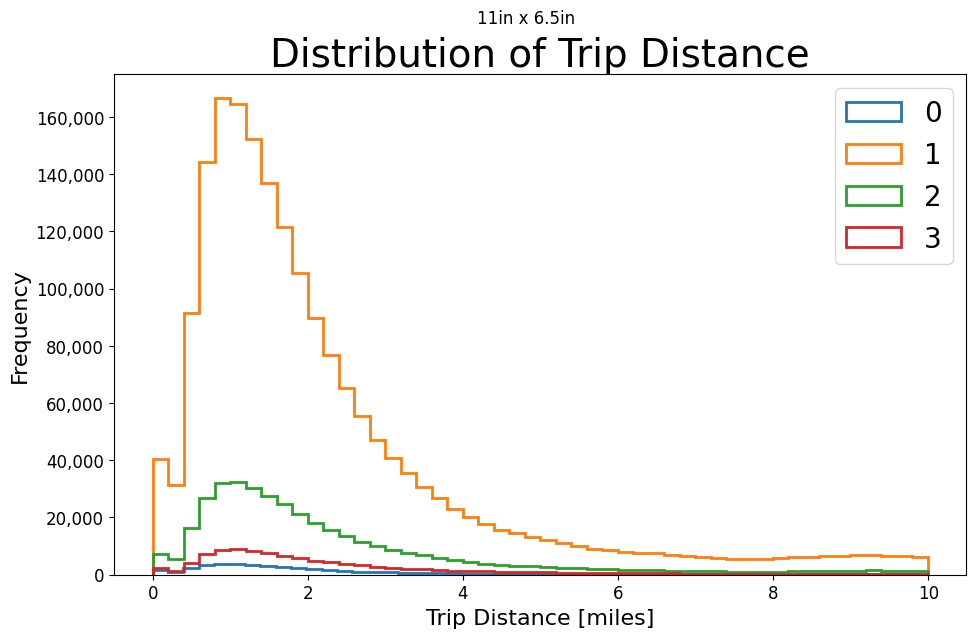

In [55]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, ] ## 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Trip Distance", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_1_110x65.png')
# plt.close()

## Distribution of Fair Amount

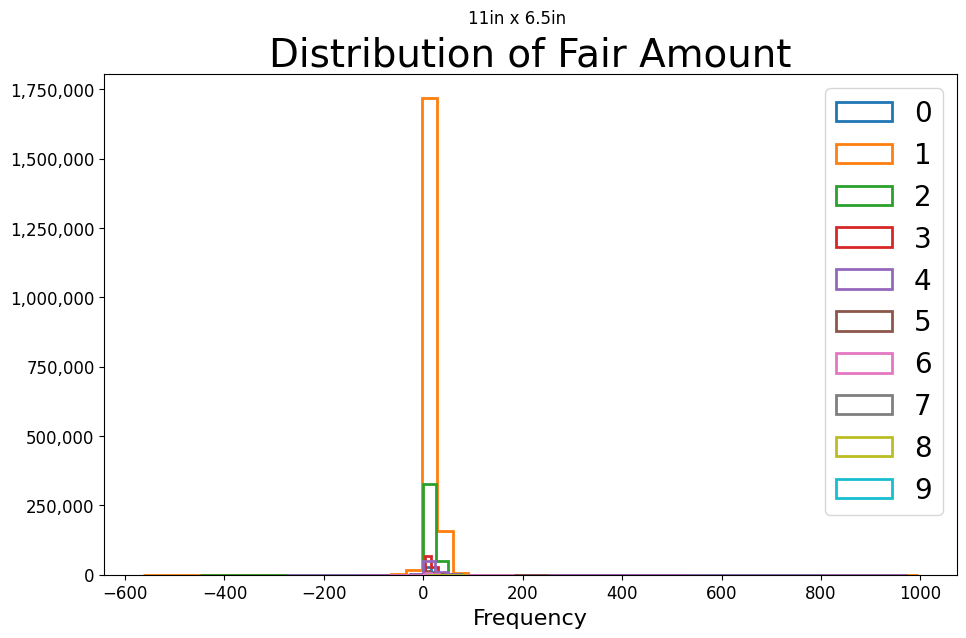

In [56]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].fare_amount, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Fare [$]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Distribution of Fair Amount", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_2_110x65.png')
# plt.close()

## Include Data Quality Table

Create a table

In [57]:
quality_numeric = df.describe().T
display(quality_numeric)

,count,mean,min,25%,50%,75%,max,std
VendorID,"2,907,108.00",1.75,1.00,1.00,2.00,2.00,6.00,0.44
tpep_pickup_datetime,2907108,2023-07-17 07:00:55.245676,2002-12-31 22:27:05,2023-07-10 09:39:33.500000,2023-07-17 15:12:16,2023-07-24 18:17:25,2023-10-16 15:21:27,NaN
tpep_dropoff_datetime,2907108,2023-07-17 07:17:59.843953,2002-12-31 22:46:37,2023-07-10 09:57:10.750000,2023-07-17 15:30:49,2023-07-24 18:32:05,2023-10-16 21:37:44,NaN
passenger_count,"2,822,022.00",1.40,0.00,1.00,1.00,1.00,9.00,0.92
trip_distance,"2,907,108.00",4.49,0.00,1.06,1.81,3.58,"191,944.96",257.88
RatecodeID,"2,822,022.00",1.61,1.00,1.00,1.00,1.00,99.00,7.19
PULocationID,"2,907,108.00",163.23,1.00,132.00,161.00,231.00,265.00,63.72
DOLocationID,"2,907,108.00",162.23,1.00,113.00,162.00,233.00,265.00,70.05
payment_type,"2,907,108.00",1.21,0.00,1.00,1.00,1.00,4.00,0.57
fare_amount,"2,907,108.00",19.70,-602.90,9.30,13.50,21.90,"1,040.40",19.84


Export to Excel:

In [58]:
quality_numeric.to_excel('table_quality_numeric.xlsx', index_label='field')

Download Excel file, and drag onto the PowerPoint slide.